In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

from pyspark.sql import SparkSession
import db_connection as dbcon

In [2]:
db_config = dbcon.config_gsql

spark = SparkSession.builder \
    .appName("process_tx") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "32g") \
    .getOrCreate()

23/06/22 17:11:41 WARN Utils: Your hostname, NatRng-MBP.local resolves to a loopback address: 127.0.0.1; using 10.40.227.150 instead (on interface en0)
23/06/22 17:11:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/22 17:11:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
#read the data
url = f"jdbc:mariadb://{db_config['host']}:{db_config['port']}/{db_config['database']}"
user = db_config['user']
password = db_config['password']
transactions_df = spark.read.format('jdbc').options(url=url, dbtable='Transactions', user=user, password=password).load()
transactions_df = transactions_df.fillna(0)
#save to parquet
transactions_df.write.parquet("data/parquet_files/transactions.parquet")
#export the data to pandas dataframe

In [4]:
tx_df = pd.read_parquet("data/parquet_files/transactions.parquet")

In [5]:
tx_df.fillna(0, inplace=True)

In [6]:
asset_encoder = LabelEncoder()
hash_encoder = LabelEncoder()
erc1155_encoder = LabelEncoder()
erc721_encoder = LabelEncoder()
token_id_encoder = LabelEncoder()

tx_df['asset'] = tx_df['asset'].astype(str)
tx_df['erc1155_token_id'] = tx_df['erc1155_token_id'].astype(str)
tx_df['erc721_token_id'] = tx_df['erc721_token_id'].astype(str)
tx_df['token_id'] = tx_df['token_id'].astype(str)
tx_df['asset_value'] = tx_df['asset_value'].astype(float)
tx_df['asset_id'] = asset_encoder.fit_transform(tx_df['asset'])
tx_df['hash_id'] = hash_encoder.fit_transform(tx_df['tx_hash'])
tx_df['erc1155_id'] = erc1155_encoder.fit_transform(tx_df['erc1155_token_id'])
tx_df['erc721_id'] = erc721_encoder.fit_transform(tx_df['erc721_token_id'])
tx_df['tk_id'] = token_id_encoder.fit_transform(tx_df['token_id'])


In [8]:
data = tx_df[['hash_id', 'from_id', 'to_id', 'tk_id', 'asset_id', 'asset_value', 'erc721_id', 'erc1155_id', 'erc1155_value']]
data.to_parquet("data/parquet_files/data_tx_df.parquet")

#save encoders to pickle files
pickle.dump(asset_encoder, open('data/encoders/asset_encoder.pkl', 'wb'))
pickle.dump(hash_encoder, open('data/encoders/hash_encoder.pkl', 'wb'))
pickle.dump(erc1155_encoder, open('data/encoders/erc1155_encoder.pkl', 'wb'))
pickle.dump(erc721_encoder, open('data/encoders/erc721_encoder.pkl', 'wb'))
pickle.dump(token_id_encoder, open('data/encoders/token_id_encoder.pkl', 'wb'))


In [9]:
data = pd.read_parquet("data/parquet_files/data_tx_df.parquet")
data_sample = data.sample(frac=0.1, random_state=42)
data_sample.to_parquet("data/parquet_files/data_tx_df_sample.parquet")


In [2]:
data_sample = pd.read_parquet("data/parquet_files/data_tx_df_sample.parquet")
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_sample)

# Perform initial PCA on the subset data
pca_initial = PCA()
pca_initial.fit(scaled_data)

# Plot the cumulative explained variance ratio
explained_variance_ratio_cumsum = np.cumsum(pca_initial.explained_variance_ratio_)
# Plot explained_variance_ratio_cumsum to visualize the explained variance

# Determine the number of components to retain based on desired variance threshold
variance_threshold = 0.9  # Example: retain 90% of the total variance
num_components = np.argmax(explained_variance_ratio_cumsum >= variance_threshold) + 1
print("Number of components to retain:", num_components)

Number of components to retain: 7


In [6]:
data = pd.read_parquet("data/parquet_files/data_tx_df.parquet")
scaler = StandardScaler()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=7)
pca_components = pca.fit_transform(scaled_data)

In [7]:
pca_df = pd.DataFrame(data=pca_components, columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7'])
pca_df.to_parquet("data/parquet_files/pca_data.parquet")

In [2]:
# from azureml.core import Workspace, Dataset

# subscription_id = '39d52177-257b-4e97-b58b-b7330a83be8d'
# resource_group = 'ml-remote-compute'
# workspace_name = 'RemoteCompute'

# workspace = Workspace(subscription_id, resource_group, workspace_name)

# data  = Dataset.get_by_name(workspace, name='pca_parquet')
# pca_data = data.to_pandas_dataframe()
pca_data = pd.read_parquet("data/parquet_files/pca_data.parquet")
pca_data_sample = pca_data.sample(frac=0.1, random_state=42)

Suggested eps value: 1.5814051528608501


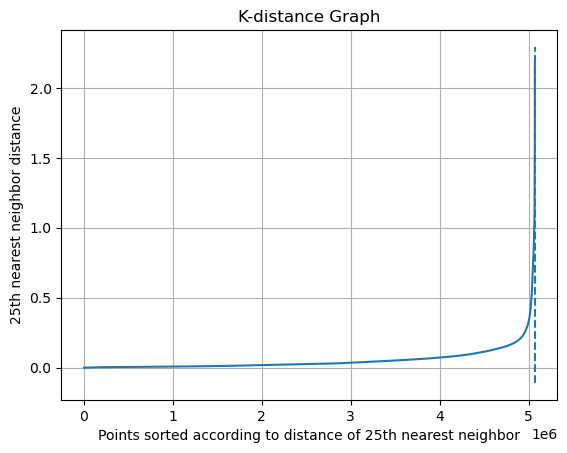

In [3]:
# assuming X is your data
X = pca_data_sample

# Let's say min_samples is 5
min_samples = 22

# Compute the distances to the 5th nearest neighbor (min_samples - 1)
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
nearest_neighbors_fit = nearest_neighbors.fit(X)
distances, indices = nearest_neighbors_fit.kneighbors(X)

# Sort distance values by ascending value and plot
distances = np.sort(distances[:, min_samples-1], axis=0)

# Use 'kneed' to find the knee/elbow
knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
print("Suggested eps value:", distances[knee_locator.knee])

plt.plot(distances)
plt.xlabel('Points sorted according to distance of {} nearest neighbor'.format(min_samples))
plt.ylabel('{} nearest neighbor distance'.format(min_samples))
plt.title('K-distance Graph')
plt.grid(True)
plt.vlines(knee_locator.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [3]:
# pca_data = pd.read_parquet("data/parquet_files/pca_data.parquet")
# Define DBSCAN parameters
min_samples = 22  # Minimum number of samples in a neighborhood

# Create an instance of DBSCAN
optics = OPTICS(min_samples=min_samples)

# Fit the DBSCAN model to the data
optics.fit(pca_data_sample)

# Access the cluster labels
labels = optics.labels_

KeyboardInterrupt: 

In [ ]:
with open('data/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [ ]:
# import os, uuid
# from azure.identity import DefaultAzureCredential
# from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
# from azure.identity import DefaultAzureCredential

# try:
#     account_url = "https://remotecompute2462890255.blob.core.windows.net"
#     default_credential = DefaultAzureCredential()

#     # Create the BlobServiceClient object
#     blob_service_client = BlobServiceClient(account_url, credential=default_credential)
#     # Create a unique name for the container
#     container_name = str(uuid.uuid4())
#     # Create the container
#     container_client = blob_service_client.create_container(container_name)
#     # Create a local directory to hold blob data
#     local_path = "./data"
#     os.mkdir(local_path)

#     # Create a file in the local data directory to upload and download
#     local_file_name = str(uuid.uuid4()) + ".txt"
#     upload_file_path = os.path.join(local_path, local_file_name)

#     # Write text to the file
#     with open(upload_file_path, 'wb') as file:
#         pickle.dump(labels, file)

#     # Create a blob client using the local file name as the name for the blob
#     blob_client = blob_service_client.get_blob_client(container=container_name, blob=local_file_name)

#     print("\nUploading to Azure Storage as blob:\n\t" + local_file_name)

#     # Upload the created file
#     with open(file=upload_file_path, mode="rb") as data:
#         blob_client.upload_blob(data)

# except Exception as ex:
#     print('Exception:')
#     print(ex)